# **1. CLASIFICACIÓN MEDIANTE MODELO/ENTRENAMIENTO**

In [116]:
import csv
import re
import pandas as pd
import numpy as np
import nltk
from nltk import TweetTokenizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, chi2, f_classif
from sklearn.metrics import classification_report, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Importamos el Dataset o corpus de entrenamiento con el label "sentimiento"
dataset = pd.read_csv('1-manualDataset1.csv', encoding = "utf-8")
print(dataset.shape)
dataset.head()

(2136, 10)


,id,date,user_displayname,user_followers_count,user_location,place_name,place_country,like_count,content,sentiment
0,1453125238959529984,2021-10-26 22:23:49+00:00,José Rafael Vilar,671,Santa Cruz de la Sierra,NaN,NaN,0,Dosis llegadas hasta ayer: 15.076.036 dosis (S...,neu
1,1453061704103902976,2021-10-26 18:11:21+00:00,Dexanfetamina,1665,Santa Cruz de la Sierra,NaN,NaN,38,Me vacuné con la segunda de Sputnik y ya sient...,neu
2,1450468450384625920,2021-10-19 14:26:41+00:00,A Gonzalez Rioja,811,Bolivia,Bolivia,Bolivia,2,Nadie usa la vacuna #AstraZeneca como tercera ...,neg
3,1440850052121914880,2021-09-23 01:26:36+00:00,Gustavo Heredia,678,Aquí y ahora,Bolivia,Bolivia,2,"Sputnik + bajación, mala combinación. Dice l...",neg
4,1440745354081701888,2021-09-22 18:30:34+00:00,Luis Angulo,6,"Cochabamba, Bolivia",Bolivia,Bolivia,1,@drhuerta hace días recién me vacunaron la 2da...,neu


In [134]:
# Contamos los valores de sentimiento y nos aseguramos que no existan valores nulos
dataset['sentiment'].value_counts()

pos    859
neg    652
neu    625
Name: sentiment, dtype: int64

In [5]:
# Definimos nuestro dataset con datos iniciales para el entrenamiento
X = dataset['content']
y = dataset['sentiment']

# **PREPROCESAMIENTO**

In [6]:
# Definimos una clase que servira para el preprocesamiento de mensajes de texto, con su función principal preprocess
# Esta funcion realiza muchas funciones como: volver a minúsculas, eliminar tíldes, eliminar saltos de línea, traduce algunas jergas del español
# Normaliza algunos textos como risas, hashtag, menciones, url, dependiendo de si queremos que realize esta función
# Realiza el stemming el texto tokenizado
class Preprocessor:

    MENTION = 'twmention'
    HASHTAG = 'twhashtag'
    URL = 'twurl'
    LAUGH = 'twlaugh'

    DIACRITICAL_VOWELS = [('á','a'), ('é','e'), ('í','i'), ('ó','o'), ('ú','u'), ('ü','u')]
    SLANG = [('d','de'), ('[qk]','que'), ('xo','pero'), ('xa', 'para'), ('[xp]q','porque'),('es[qk]', 'es que'),
              ('fvr','favor'),('(xfa|xf|pf|plis|pls|porfa)', 'por favor'), ('dnd','donde'), ('tb', 'también'),
              ('(tq|tk)', 'te quiero'), ('(tqm|tkm)', 'te quiero mucho'), ('x','por'), ('\+','mas')]

    _stemmer = SnowballStemmer('spanish')
    _tokenizer = TweetTokenizer().tokenize

    def __init__(self, twitter_features=None, stemming=False):
        self._twitter_features = twitter_features
        self._stemming = stemming

    def preprocess(self, message):
        # convertir a minúscula
        message = message.lower()
        # remover números, retornos de carro, saltos de línea y 'RT'
        message = re.sub(r'(\d+|\n|\brt\b)', '', message)
        # remover tíldes
        for s,t in self.DIACRITICAL_VOWELS:
            message = re.sub(r'{0}'.format(s), t, message)
        # remover caracteres repetidos
        message = re.sub(r'(.)\1{2,}', r'\1\1', message)
        # normalizar risas o carcajadas
        message = self.normalize_laughs(message)
        # traducir jerga
        for s,t in self.SLANG:
            message = re.sub(r'\b{0}\b'.format(s), t, message)

        # aplicacamos la limpieza o normalizacion de hashtags, menciones o enlaces web
        message = self.process_twitter_features(message, self._twitter_features)

        # aplicamos el stemming de ser necesario al mensaje tokenizado
        if self._stemming:
            message = ' '.join(self._stemmer.stem(w) for w in self._tokenizer(message))

        return message

    @staticmethod
    def process_twitter_features(message, twitter_features):
        message = re.sub(r'[\.\,]http','. http', message, flags=re.IGNORECASE)
        message = re.sub(r'[\.\,]#', '. #', message)
        message = re.sub(r'[\.\,]@', '. @', message)

        if twitter_features == 'remove':
            # remueve menciones, hashtags and urls
            message = re.sub(r'((?<=\s)|(?<=\A))(@|#)\S+', '', message)
            message = re.sub(r'\b(https?:\S+)\b', '', message, flags=re.IGNORECASE)
        elif twitter_features == 'normalize':
            # normaliza menciones, hashtags and urls
            message = re.sub(r'((?<=\s)|(?<=\A))@\S+', Preprocessor.MENTION, message)
            message = re.sub(r'((?<=\s)|(?<=\A))#\S+', Preprocessor.HASHTAG, message)
            message = re.sub(r'\b(https?:\S+)\b', Preprocessor.URL, message, flags=re.IGNORECASE)

        return message

    @staticmethod
    def normalize_laughs(message):
        message = re.sub(r'\b(?=\w*[j])[aeiouj]{4,}\b', Preprocessor.LAUGH, message, flags=re.IGNORECASE)
        message = re.sub(r'\b(juas+|lol)\b', Preprocessor.LAUGH, message, flags=re.IGNORECASE)
        return message

    def __str__(self):
        return "Preprocessor([twitter_features={0}, stemming={1}])".format(self._twitter_features, self._stemming)

    def __repr__(self):
        return "Preprocessor([twitter_features={0}, stemming={1}])".format(self._twitter_features, self._stemming)

In [7]:
# Definimos algunas funciones para la búsqueda de la combinación del mejor modelo y sus parámetros

# Definimos una variable que contenga palabras vacías (stop words) en idioma español
spanish_stopwords = stopwords.words('spanish')

In [8]:
# Definimos el Tokenizer para volver al texto en pequeñas unidades de token
tokenizer = TweetTokenizer().tokenize

In [9]:
# Definimos las funciones de ponderación TF & TF-IDF, y le pasamos la función de tokenización
bow_tf = TfidfVectorizer(use_idf=False, tokenizer=tokenizer)
bow_tfidf = TfidfVectorizer(use_idf=True, tokenizer=tokenizer)

In [13]:
# Definimos la función de validación cruzada (cross validation) con 5 grupos de entrenamiento
skfold = StratifiedKFold(n_splits=5, shuffle=True)

**Búsqueda del modelo para la clasificación**

In [46]:
# Definimos las métricas que queremos como resultado
scoring = {'accuracy': 'accuracy',
           'precision_macro': 'precision_macro',
           'recall_macro': 'recall_macro',
           'f1_macro': 'f1_macro',
           'precision_micro': 'precision_micro',
           'recall_micro': 'recall_micro',
           'f1_micro': 'f1_micro',
           'precision_weighted': 'precision_weighted',
           'recall_weighted': 'recall_weighted',
           'f1_weighted': 'f1_weighted'}

In [47]:
# Definimos el Pipeline
pipeline = Pipeline([('vectorizer', None),
                     ('classifier', None)])

In [48]:
# Ejecutamos el Pipeline con los parámetros establecidos, y procedemos a la búsqueda de la mejor combinación
# El resultado lo guardaremos en un archivo csv para su posterior análisis
parameters = [{
    'vectorizer': (bow_tf, 
                   bow_tfidf),
    'vectorizer__preprocessor': (Preprocessor(twitter_features='remove',    stemming=True).preprocess,
                                 Preprocessor(twitter_features='normalize', stemming=True).preprocess,
                                 Preprocessor(twitter_features='remove',    stemming=False).preprocess,
                                 Preprocessor(twitter_features='normalize', stemming=False).preprocess),
    'vectorizer__stop_words': (spanish_stopwords, 
                               None),
    'classifier': (MultinomialNB(), 
                   LinearSVC(), 
                   LogisticRegression(),
                   DecisionTreeClassifier())
}]
grid_search = GridSearchCV(
    pipeline, 
    param_grid=parameters, 
    n_jobs=-1, 
    cv=skfold, 
    verbose=5, 
    scoring=scoring,
    refit='f1_weighted',
    return_train_score=False)

grid_search.fit(X, y)
print("best_score:", grid_search.best_score_)
pd.DataFrame(grid_search.cv_results_).to_csv(path_or_buf='resultsBase.csv', quoting=csv.QUOTE_NONNUMERIC)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
best_score: 0.6860736295975548


Después de esperar un periodo de tiempo donde se reliza la búsqueda de la mejor combinación para extraer un modelo que sea capaz de realizar la clasificación

**RESULTADOS**

In [49]:
results = pd.read_csv('resultsBase.csv')

(64, 90)


In [66]:
mnb = results[0:16].sort_values('rank_test_f1_weighted')[:1].iloc[0]['rank_test_f1_weighted']
svm = results[17:32].sort_values('rank_test_f1_weighted')[:1].iloc[0]['rank_test_f1_weighted']
log = results[33:48].sort_values('rank_test_f1_weighted')[:1].iloc[0]['rank_test_f1_weighted']
tre = results[49:64].sort_values('rank_test_f1_weighted')[:1].iloc[0]['rank_test_f1_weighted']

37


In [110]:
results.head(16)

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_vectorizer,param_vectorizer__preprocessor,param_vectorizer__stop_words,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision_macro,split1_test_precision_macro,split2_test_precision_macro,split3_test_precision_macro,split4_test_precision_macro,mean_test_precision_macro,std_test_precision_macro,rank_test_precision_macro,split0_test_recall_macro,split1_test_recall_macro,split2_test_recall_macro,split3_test_recall_macro,split4_test_recall_macro,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,...,split0_test_recall_micro,split1_test_recall_micro,split2_test_recall_micro,split3_test_recall_micro,split4_test_recall_micro,mean_test_recall_micro,std_test_recall_micro,rank_test_recall_micro,split0_test_f1_micro,split1_test_f1_micro,split2_test_f1_micro,split3_test_f1_micro,split4_test_f1_micro,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro,split0_test_precision_weighted,split1_test_precision_weighted,split2_test_precision_weighted,split3_test_precision_weighted,split4_test_precision_weighted,mean_test_precision_weighted,std_test_precision_weighted,rank_test_precision_weighted,split0_test_recall_weighted,split1_test_recall_weighted,split2_test_recall_weighted,split3_test_recall_weighted,split4_test_recall_weighted,mean_test_recall_weighted,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,0,2.634989,0.024623,0.678511,0.011692,MultinomialNB(),"TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fb29c4ee850>>,\n use_idf=False)","<bound method Preprocessor.preprocess of Preprocessor([twitter_features=remove, stemming=True])>","['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'esté', 'estés', 'estemos', 'estéis', 'estén', 'estaré', 'estarás', 'estará', 'estaremos', 'estaréis', 'estarán', 'estaría', 'estarías', 'estaríamos', 'estaríais', 'estarían', 'estaba', 'estabas', 'estábamos', 'estabais', 'estaban', 'estuve', 'estuviste', 'estuvo', 'estuvimos', 'estuvisteis', 'estuvieron', 'estuviera', 'estuvieras', 'estuviéramos', 'estuvierais', 'estuvieran', 'estuviese', 'estuvieses', 'estuviésemos', 'estuvieseis', 'estuviesen', 'estando', 'estado', 'estada', 'estados', 'estadas', 'estad', 'he', 'has', 'ha', 'hemos', 'habéis', 'han', 'haya', 'hayas', 'hayamos', 'hayáis', 'hayan', 'habré', 'habrás', 'habrá', 'habremos', 'habréis', 'habrán', 'habría', 'habrías', 'habríamos', 'habríais', 'habrían', 'había', 'habías', 'habíamos', 'habíais', 'habían', 'hube', 'hubiste', 'hubo', 'hubimos', 'hubisteis', '

In [ ]:
dr = results[['param_classifier', 'param_vectorizer', 'param_vectorizer__preprocessor', 'param_vectorizer__stop_words', 'params', 
              'mean_test_accuracy', 'mean_test_precision_weighted', 'mean_test_recall_weighted', 'mean_test_f1_weighted', 'rank_test_f1_weighted']]
dr = dr.loc[(dr['rank_test_f1_weighted'] == mnb) | (dr['rank_test_f1_weighted'] == svm) | (dr['rank_test_f1_weighted'] == log) | (dr['rank_test_f1_weighted'] == tre)]
# dr.insert(0, "classifier", np.nan, allow_duplicates=False)
# for i in dr.index: 
#   if 'MultinomialNB' in str(dr['param_classifier'][i]):
#     dr['classifier'][i] = 'MultinomialNB'
#   if 'LinearSVC' in str(dr['param_classifier'][i]):
#     dr['classifier'][i] = 'LinearSVC'
#   if 'DecisionTreeClassifier' in str(dr['param_classifier'][i]):
#     dr['classifier'][i] = 'DecisionTreeClassifier'
#   if 'LogisticRegression' in str(dr['param_classifier'][i]):
#     dr['classifier'][i] = 'LogisticRegression'

In [112]:
pd.set_option('display.max_colwidth', -1)
dr.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,classifier,param_classifier,param_vectorizer,param_vectorizer__preprocessor,param_vectorizer__stop_words,params,mean_test_accuracy,mean_test_precision_weighted,mean_test_recall_weighted,mean_test_f1_weighted,rank_test_f1_weighted
8,MultinomialNB,MultinomialNB(),"TfidfVectorizer(preprocessor=<bound method Preprocessor.preprocess of Preprocessor([twitter_features=normalize, stemming=True])>,\n tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fb29c4ee850>>)","<bound method Preprocessor.preprocess of Preprocessor([twitter_features=remove, stemming=True])>","['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'esté', 'estés', 'estemos', 'estéis', 'estén', 'estaré', 'estarás', 'estará', 'estaremos', 'estaréis', 'estarán', 'estaría', 'estarías', 'estaríamos', 'estaríais', 'estarían', 'estaba', 'estabas', 'estábamos', 'estabais', 'estaban', 'estuve', 'estuviste', 'estuvo', 'estuvimos', 'estuvisteis', 'estuvieron', 'estuviera', 'estuvieras', 'estuviéramos', 'estuvierais', 'estuvieran', 'estuviese', 'estuvieses', 'estuviésemos', 'estuvieseis', 'estuviesen', 'estando', 'estado', 'estada', 'estados', 'estadas', 'estad', 'he', 'has', 'ha', 'hemos', 'habéis', 'han', 'haya', 'hayas', 'hayamos', 'hayáis', 'hayan', 'habré', 'habrás', 'habrá', 'habremos', 'habréis', 'habrán', 'habría', 'habrías', 'habríamos', 'habríais', 'habrían', 'había', 'habías', 'habíamos', 'habíais', 'habían', 'hube', 'hubiste', 'hubo', 'hubimos', 'hubisteis', 'hubieron', 'hubiera', 'hubieras', 'hubiéramos', 'hubierais', 'hubieran', 'hubiese', 'hubieses', 'hubiésemos', 'hubieseis', 'hubiesen', 'habiendo', 'habido', 'habida', 'habidos', 'habidas', 'soy', 'eres', 'es', 'somos', 'sois', 'son', 'sea', 'seas', 'seamos', 'seáis', 'sean', 'seré', 'serás', 'será', 'seremos', 'seréis', 'serán', 'sería', 'serías', 'seríamos', 'seríais', 'serían', 'era', 'eras', 'éramos', 'erais', 'eran', 'fui', 'fuiste', 'fue', 'fuimos', 'fuisteis', 'fueron', 'fuera', 'fueras', 'fuéramos', 'fuerais', 'fueran', 'fuese', 'fueses', 'fuésemos', 'fueseis', 'fuesen', 'sintiendo', 'sentido', 'sentida', 'sentidos', 'sentidas', 'siente', 'sentid', 'tengo', 'tienes', 'tiene', 'tenemos', 'tenéis', 'tienen', 'tenga', 'tengas', 'tengamos', 'tengáis', 'tengan', 'tendré', 'tendrás', 'tendrá', 'tendremos', 'tendréis', 'tendrán', 'tendría', 'tendrías', 'tendríamos', 'tendríais', 'tendrían', 'tenía', 'tenías', 'teníamos', 'teníais', 'tenían', 'tuve', 'tuviste', 'tuvo', 'tuvimos', 'tuvisteis', 'tuvieron', 'tuviera', 'tuvieras', 'tuviéramos', 'tuvierais', 'tuvieran', 'tuviese', 'tuvieses', 'tuviésemos', 'tuvieseis', 'tuviesen', 'teniendo', 'tenido', 'tenida', 'tenidos', 'tenidas', 'tened']","{'classifier': MultinomialNB(), 'vectorizer': TfidfVectorizer(preprocessor=<bound method Preprocessor.preprocess of Preprocessor([twitter_features=normalize, stemming=True])>,\n tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fb29c4ee850>>), 'vectorizer__preprocessor': <bound method Preprocessor.pre

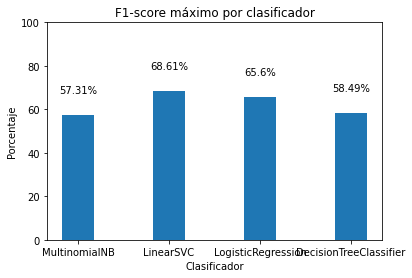

In [117]:
# Visualizamos el porcentaje del mejor resultado de cada clasificador tomando como score el F1-score
width = 0.35
fig, ax = plt.subplots()
pps = ax.bar(dr['classifier'], dr['mean_test_f1_weighted'] * 100, width, align='center')
for p in pps:
  ax.text(x=p.get_x() + p.get_width() / 2, y=p.get_height() + 10, s="{}%".format(round(p.get_height(), 2)), ha='center')
plt.title("F1-score máximo por clasificador")
plt.ylabel("Porcentaje")
plt.xlabel("Clasificador")
plt.ylim([0, 100])
plt.show()

## **MEJORAMIENTO DEL MODELO SVM**

In [ ]:
# Volvemos a invocar a nuestro dataset de trabajo
# dataset = pd.read_csv('', encoding = "utf-8")
# X = dataset['content']
# y = dataset['sentiment']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) 

In [21]:
# Definimos 4 extractores que permitira la creración de una nueva columan donde ira contabilizando el número de ocurrencias de alguna palabra
from preprocessor import Preprocessor # Es la misma clase del Preprocesador de texto que simplemente se encuentra ahora en un archivo externo
from lexicon_extractor import LexiconExtractor # Extractor de léxico, contabiliza las palabras positivas o negativas de acuerdo a un diccionario
from symbol_extractor import SentimentSymbolExtractor # Extractor de emoticones, contabiliza los emoticones de acuerdo a un diccionario de emoticones
from laugh_extractor import LaughExtractor # Extractor de risas y carcajadas, contabiliza las carcajadas y los contabiliza

# La idea es evaluar si exte tipo de normalización, contabilizando el numero de ocurrencias, si son indicadores que mejoran el modelo inicial

In [106]:
# Definimos la función de ponderación recomendada con el buscador, con los parámteros mejor puntuados
func_preprocessor = Preprocessor(twitter_features='remove', stemming=True).preprocess
bow_term_frequency_idf = TfidfVectorizer(use_idf=True, tokenizer=tokenizer, preprocessor=func_preprocessor, stop_words=None)

In [107]:
# Entrenamos el modelo con los parámetros ya anteriormente probados
model = Pipeline([
    ('feats', FeatureUnion([
           ('vectorizer', bow_term_frequency_idf),
           ('sentiment_symbol', SentimentSymbolExtractor()),
           ('lexicon', LexiconExtractor()),
           ('laugh', LaughExtractor()),
    ])),
    ("fs", SelectKBest(score_func=chi2, k='all')),
    ('classifier', LinearSVC(C=1))
])

model.fit(X_train, y_train)

y_prediction = model.predict(X_test)

report = classification_report(y_test, y_prediction, digits=4)

print(report)
print(accuracy_score(y_test, y_prediction))

              precision    recall  f1-score   support

         neg     0.7697    0.7987    0.7840       159
         neu     0.6667    0.5786    0.6195       159
         pos     0.7316    0.7824    0.7562       216

    accuracy                         0.7266       534
   macro avg     0.7227    0.7199    0.7199       534
weighted avg     0.7236    0.7266    0.7237       534

0.7265917602996255


0.7265917602996255


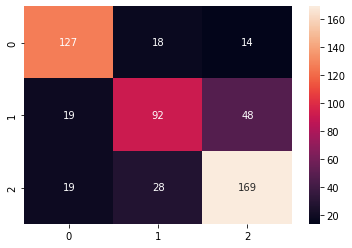

In [108]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import seaborn as sns
print(accuracy_score(y_test,y_prediction))
sns.heatmap(confusion_matrix(y_test,y_prediction),annot=True,fmt='.4g')

In [135]:
# Predecimos algunos mensajes de texto como ejemplo
#model = pickle.load(open('trained_model.pickle', 'rb'))
demo = model.predict(['Esta vacuna me gusta B)', 'La vacuna sputnik no me genera confianza :('])
print(demo)

['pos' 'neg']


# **2. CLASIFICACIÓN MEDIANTE CLOUD SERVICE**

In [ ]:
# Obtenemos los datos, se utilizará el mismo dataset para la evaluación
df = pd.read_csv('1-manualDataset1.csv', encoding = "utf-8")

In [ ]:
# Instalamos la libreria MeaningCloud
!pip install MeaningCloud-python
import meaningcloud

In [ ]:
# Añadimos algunas columnas donde extraeremos la información devuelta por el API
df['sentiment_mc'] = np.nan
df['irony_mc'] = np.nan
df['subjetivity_mc'] = np.nan

In [ ]:
# Definimos la función que obtendrá la polarida y otros datos, previamente debemos registrarnos en MeaningCloud y obtener la llave de licencia para empezar a utilizarlo
license_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
for i in df.index: 
  sentiment_response = meaningcloud.SentimentResponse(meaningcloud.SentimentRequest(license_key, lang='es', txt=df['clean_content'][i], txtf='plain').sendReq())
  if sentiment_response.isSuccessful():
    df['sentiment_mc'][i] = sentiment_response.getGlobalScoreTag()
    df['irony_mc'][i] = sentiment_response.getIrony()
    df['subjetivity_mc'][i] = sentiment_response.getSubjectivity()

In [ ]:
# Verificamos los valores que arrojó el proceso anterior en la polaridad de los tweets
df['sentiment_mc'].value_counts()

In [ ]:
# Para reducir la categorización de la polaridad se implementa la siguiente función
def reduce_classify_sentiment(sentiment):
  if sentiment == 'P' or sentiment == 'P+':
    return 'Positive'
  if sentiment == 'N' or sentiment == 'N+':
    return 'Negative'
  if sentiment == 'NEU' or sentiment == 'NONE':
    return 'Neutral'

df['sentiment_cloud'] = df['sentiment_mc'].apply(lambda x: reduce_classify_sentiment(x))

In [ ]:
# Guardamos los datos con la polaridad previamente obtenida
import csv
df.to_csv('meaningCloudDataset1.csv', index=False)

In [119]:
# Opcional
dcloud = pd.read_csv('2-meaningCloudDataset1.csv', encoding = "utf-8")
print(dcloud.shape)

(2136, 15)


In [128]:
# Creamos un nueva columna con la misma clasificación 
def manual_classify_sentiment(sentiment):
  if sentiment == 'pos':
    return 'Positive'
  if sentiment == 'neg':
    return 'Negative'
  if sentiment == 'neu':
    return 'Neutral'

dcloud['sentiment_manual'] = dcloud['sentiment'].apply(lambda x: manual_classify_sentiment(x))

In [129]:
print("Clasificación Cloud Service")
print(dcloud['sentiment_cloud'].value_counts())

print("\nClasificación Manual")
print(dcloud['sentiment_manual'].value_counts())

Clasificación Cloud Service
Positive    937
Negative    646
Neutral     553
Name: sentiment_cloud, dtype: int64

Clasificación Manual
Positive    859
Negative    652
Neutral     625
Name: sentiment_manual, dtype: int64


In [130]:
# Medimos los resultados
y_test = dcloud['sentiment_manual'].tolist() 
y_pred = dcloud['sentiment_cloud'].tolist()

0.8932584269662921


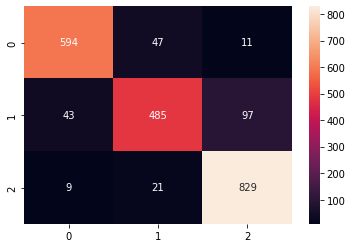

In [131]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import seaborn as sns

print(accuracy_score(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.4g', )

In [142]:
report2 = classification_report(y_test, y_pred, digits=4)

print(report2)
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

    Negative     0.9195    0.9110    0.9153       652
     Neutral     0.8770    0.7760    0.8234       625
    Positive     0.8847    0.9651    0.9232       859

    accuracy                         0.8933      2136
   macro avg     0.8938    0.8840    0.8873      2136
weighted avg     0.8931    0.8933    0.8916      2136

0.8932584269662921
